## Site Stratified Dataset Split and Transforms

Competition Score: 1.5254

In [1]:
from utils import verify_data, plot_species_grid, verify_splits, split_data

%matplotlib inline

import os
import wandb
import random
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn 
import torchvision.models as models
from torchvision import transforms
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from PIL import Image

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
print(torch.__version__)
print(torch.backends.mps.is_available())

# Determine whether to use MPS (Metal Performance Shaders) or fallback to CPU
device = "mps" if torch.backends.mps.is_available() else "cpu"

2.5.1
True


In [3]:
%pip install wandb -qU

Note: you may need to restart the kernel to use updated packages.


Refresh this sell for each run. If not using macOS, make sure to set you seed for cuda if necessary.

In [36]:
seed = 1
random.seed(seed)  # Python random seed
np.random.seed(seed)  # NumPy random seed
torch.manual_seed(seed)  # PyTorch CPU and CUDA seed

# If using multiple threads or workers, you can optionally set:
# torch.use_deterministic_algorithms(True)  # Enforces deterministic behavior

### Initialize Constants

This ensures consistency, so what we change in the model is logged properly. 

In [37]:
NUM_CLASSES = 8  # Number of target classes

# Constants for the model experiments and logging
RESNET50_WEIGHTS = models.ResNet50_Weights.DEFAULT  # Pre-trained weights
HIDDEN_UNITS1 = 100  # Number of units in the hidden fully connected layer



TRAIN_TRANSFORMS = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match model input
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip horizontally
    transforms.RandomRotation(15),  # Rotate within ±15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),  # Convert PIL image to tensor
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # Normalize using ImageNet stats
])


# TRAIN_TRANSFORMS = transforms.Compose([
#     transforms.Resize((224, 224)),
#                     transforms.ToTensor(),
#                     transforms.Normalize(
#                         mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
# ])


# Hyperparmeters
EPOCHS = 5
DROPOUT_RATE = 0.1  # Dropout rate for regularization
BATCH_SIZE = 32
LR = 0.01
MOMENTUM = 0.09

# Logging params
NUM_BATCHES_TO_LOG = 10 # from the test data for each test step
NUM_IMAGES_PER_BATCH = 32 # Number of images to log per test batch


Make sure you add the data to the base_path on your local machine if running locally. We have a git ignore set up so the data folder synch remotely. 

In [38]:
# Define the base path where images are stored
base_path = "./data/givens/"
train_features = pd.read_csv(f"{base_path}train_features.csv", index_col="id")
test_features = pd.read_csv(f"{base_path}test_features.csv", index_col="id")
train_labels = pd.read_csv(f"{base_path}train_labels.csv", index_col="id")

The `features` CSVs contain the image ID, filepath and site ID for each image.

In [7]:
print(test_features['filepath'].dtype)
print(test_features['filepath'].isnull().sum())
print(train_features['filepath'].isnull().sum())  # Count any NaN values

object
0
0


In [39]:
# Add a 'filepath' column with the full path to each image
# Subdirectories for train and test images
train_images_path = os.path.join(base_path, "train_features")
test_images_path = os.path.join(base_path, "test_features")

train_features['filepath'] = train_features.index.map(
    lambda img_id: os.path.join(train_images_path, f"{img_id}.jpg"))

test_features['filepath'] = test_features.index.map(
    lambda img_id: os.path.join(test_images_path, f"{img_id}.jpg"))

Store a sorted list of the labels, so that we can sort the inputs and outputs to our model in a consistent way.

In [40]:
species_labels = sorted(train_labels.columns.unique())
# species_labels

### Explore the data (Optional)

In [ ]:
# helper function (optional)
verify_data(train_features,test_features, train_labels)

In [ ]:
# helper function (optional)
plot_species_grid(train_features, train_labels, species_labels)

There's a lot more data exploration to do. For example, you might also want to look at the distribution of image dimensions or camera trap sites. But since our primary goal here is to develop a benchmark, let's move on to the modeling!

### Split into train and evaluation sets

We need to ensure that sites are mutually exclusive between the training and validation sets, meaning no site should appear in both sets. This ensures a proper stratification based on site.

In [41]:
X_train, X_val, y_train, y_val = split_data(
    train_features, train_labels, type='sites')

In [ ]:

# Helper function (optional)
verify_splits(X_train, y_train, X_val,  y_val)

### Build the datasets

In [42]:
class ImagesDataset(Dataset):
    """Reads in an image, transforms pixel values, and serves
    a dictionary containing the image id, image tensors, and label.
    """

    def __init__(self, features, 
                 labels=None, 
                 transform=None, device=device):
        self.data = features
        self.label = labels
        self.device = device
        self.transform = transform

    def __getitem__(self, index):
    
        image_id = self.data.index[index]
        image = Image.open(self.data.iloc[index]["filepath"]).convert("RGB")

        if self.transform:
            image = self.transform(image)

        sample = {"image_id": image_id, "image": image}
     
        if self.label is not None:
            label = torch.tensor(self.label.iloc[index].values, dtype=torch.float)
            if self.device:
                label = label.to(self.device)
            sample["label"] = label

        return sample

    def __len__(self):
        return len(self.data)

Set up transformations. Model transformations are defined at the top as constants to sync with logging.

In [43]:
# Always keep validation transformation the same to reflect real world
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Ensure consistent input size
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # Normalize using ImageNet stats
])

In [44]:
# Create datasets
train_dataset = ImagesDataset(
    X_train, 
    y_train, 
    transform=TRAIN_TRANSFORMS, device=device)
val_dataset = ImagesDataset(
    X_val, 
    y_val, 
    transform=val_transform, 
    device=device)

# Create DataLoaders

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, pin_memory=True)
val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, pin_memory=True)

In [45]:
# Print shapes for verification
print(f"Training set: {len(train_dataset)} samples")
print(f"Validation set: {len(val_dataset)} samples")

Training set: 13171 samples
Validation set: 3317 samples


### Training
Current set up is pretrained ResNet50 model as our backbone. The pretrained model outputs a 2048-dimension embedding, which we will then connect to two more dense layers, with a ReLU and Dropout step in between.

These final layers, defined in `model.fc`, are the new "head" of our model, and allow us to transform the image embeddings produced by the pretrained "backbone" into the 8-dimensional output required to learn the species classification task we're tackling here. Prior to redefining it below, `model.fc` would be the final, dense layer connecting the 2048-dimension embedding to a 1000-dimension output (corresponding to the 1000 ImageNet classes that the pretrained model was trained on). We will instead prepare the model for the current task by redefining `model.fc` to produce an 8-dimensional output corresponding to our 8 species classes (including blanks).

We'll also add a couple more layers in between. The `ReLU` layer introduces non-linearity into the model head, in effect activating important features and suppressing noise. And the `Dropout` layer is a commonly used regularization component that randomly drops some nodes from the previous layer's outputs (10% of nodes in this case) during each training step, mitigating our risk of overfitting.

#### Define the model, loss, and optimizer:

In [46]:
# model = models.resnet50(pretrained=True) fixed warning
model = models.resnet50(weights=RESNET50_WEIGHTS)

# # Freeze the backbone parameters
# for param in model.parameters():
#     param.requires_grad = False

model.fc = nn.Sequential(
    nn.Linear(2048, HIDDEN_UNITS1),  # dense layer takes a 2048-dim input and outputs 100-dim
    nn.ReLU(inplace=True),  # ReLU activation introduces non-linearity
    nn.Dropout(DROPOUT_RATE),  # common technique to mitigate overfitting
    nn.Linear(HIDDEN_UNITS1, NUM_CLASSES
    ),  # final dense layer outputs 8-dim corresponding to our target classes
)
model = model.to(device)  # Move model to MPS device

criterion = nn.CrossEntropyLoss()

# # Define optimizer to only update the head's parameters
# optimizer = optim.SGD(model.fc.parameters(), lr=LR, momentum=MOMENTUM)

optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM)

#### Set up logging

Looking for output: True.

In [47]:
wandb.require()
wandb.login()

True

If you change the model or hyperparameters for experimentation, you will need to update the constants at the top of the notebook and feed the constants into the config file below. You'll need to use constants in the model too to be sure model and logs are synced. 

Keep `wandb.init(project="wildlife")` to log to our shared project.

In [48]:
# ✨ W&B: Initialize a new run to track this model's training
wandb.init(project="wildlife")

# ✨ W&B: Log anything we want to experiment with here
cfg = wandb.config
cfg.update({"epochs" : EPOCHS, "batch_size": BATCH_SIZE,
            "model": "ResNet50", "weights": RESNET50_WEIGHTS,
            "hidden_units1" : HIDDEN_UNITS1, "dropout": DROPOUT_RATE,
            "lr": LR, "momentum": MOMENTUM,
            "train_transforms": TRAIN_TRANSFORMS, 
            # num images being logged
            "img_count" : min(50, NUM_IMAGES_PER_BATCH*NUM_BATCHES_TO_LOG)})



In [49]:
def log_test_predictions(images, 
                         image_ids,
                         labels, 
                         outputs, 
                         probs,
                         predicted, 
                         test_table, 
                         counter):
                        #  preds_collector):
    """
    Log predictions, confidence scores, and true labels for a batch of test 
        images. Creating a table of results in W&B. It visualizes image 
        misclassifications.
    Args:
        images (torch.Tensor): Batch of test images.
        image_ids (list): List of IDs corresponding to the test images.
        labels (torch.Tensor): Ground-truth labels.
        outputs (torch.Tensor): Model outputs (logits).
        predicted (torch.Tensor): Predicted class indices.
        test_table (wandb.Table): W&B Table to log predictions.
        counter (int): Current count of images logged.
    """
    # Obtain confidence scores for all classes
    # scores = F.softmax(outputs.data, dim=1)
    log_scores = probs.cpu().numpy()  # Convert to NumPy for logging
    log_images = images.cpu().numpy()
    log_labels = labels.argmax(axis=1).cpu().numpy()
    log_preds = predicted.cpu().numpy()

    # Add data to W&B table
    for img, img_id, true_label, pred, conf_scores in zip(
        log_images, image_ids, log_labels, log_preds, log_scores
    ):
        if counter >= cfg["img_count"]:
            break  # Stop logging once the limit is reached

        # Convert image from [C, H, W] to [H, W, C]
        img = img.transpose(1, 2, 0)
        
        # Add data to the W&B table
        test_table.add_data(
            img_id,              # Image_ID
            wandb.Image(img),    # Image
            pred,                # Predicted class
            true_label,          # Ground-truth label
            *conf_scores         # Confidence scores for all classes
        )
        counter += 1  # Increment the counter

        # return preds_collector


#### Set up training Loop
We're now ready to train our model!

We'll start simple and just run it for one epoch, but feel free to run it for more `num_epochs` if you've got the time. We hope to see a decreasing loss as training progresses, which will provide some evidence that the model is learning. Note that we haven't frozen any weights in the pretrained model, a choice which you may want to revisit and we discuss in a little more detail below.


In [50]:
def train_one_epoch(model, train_loader, criterion, optimizer, epoch):
    """
    Train the model for one epoch.

    Args:
        model (nn.Module): The model being trained.
        train_loader (DataLoader): DataLoader for training data.
        criterion (nn.Module): Loss function.
        optimizer (Optimizer): Optimizer for training.
        epoch (int): Current epoch number.
        cfg (dict): W&B configuration.

    Returns:
        float: Average loss for all batches in the epoch. Summarizing how 
        the model is performing during this epoch
    """
    print(f"Starting training for epoch {epoch}")
    model.train()
    total_loss = 0
    # total_steps = len(train_loader) # num batches in loader
    tracking_loss = []  # List to store loss for every batch

    for batch_n, batch in enumerate(train_loader):
        images = batch["image"].to(device)
        labels = batch["label"].to(device)

        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        tracking_loss.append(loss.item())  # Store batch loss for tracking 

        # backward and optimize
        optimizer.zero_grad()
        loss.backward() # wrt
        optimizer.step()

        # ✨ W&B: Log loss over training steps, visualized in the UI live
        wandb.log({"loss" : loss, "epoch": epoch,})

        # Print progress every 100 batches
        if (batch_n + 1 ) % 100 == 0: 
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                .format(epoch+1, EPOCHS, batch_n+1, len(train_loader), loss.item()))
            
    avg_loss = total_loss / len(train_loader)
    return avg_loss, tracking_loss
                

#### Set up Evaluation Loop

In [51]:
def evaluate(model, val_loader, criterion, log_counter):
    """
    Evaluate the model on a test/validation dataset.

    Args:
        model (nn.Module): The model to evaluate.
        test_loader (DataLoader): DataLoader for test data.
        criterion (nn.Module): Loss function.
        cfg (dict): W&B configuration.

    Returns:
        dict: Metrics including accuracy and average loss.
    """
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    log_counter = 0

    # Collect all predictions and labels for metric calculations
    all_preds = []
    all_labels = []

    # ✨ Initialize the W&B table
    test_table = wandb.Table(columns=[
        "image_id", "image", "predicted", "true_label",
        "score_antelope_duiker", "score_bird", "score_blank",
        "score_civet_genet", "score_hog", "score_leopard",
        "score_monkey_prosimian", "score_rodent"
    ])
    
    with torch.no_grad():
        for batch_n, batch in enumerate(val_loader):
            images = batch["image"].to(device)
            labels = batch["label"].to(device)
            image_ids = batch["image_id"]

            # forward pass
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)  # For logging

            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, dim=1) 
            correct += (predicted == labels.argmax(dim=1)).sum().item()
            total += labels.size(0)

            # Store predictions and labels for metrics
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.argmax(dim=1).cpu().numpy())  # Convert one-hot to class indices
            

            # Log predictions (only log a limited number of batches)
            if batch_n < NUM_BATCHES_TO_LOG:
                log_test_predictions(images, image_ids, labels, 
                                     outputs,probs, predicted, 
                                     test_table,log_counter)
                log_counter += 1

    # Calculate metrics
    acc = 100 * correct / total
    avg_loss = total_loss / len(val_loader)
    precision = precision_score(all_labels, all_preds, average="weighted")
    recall = recall_score(all_labels, all_preds, average="weighted")
    f1 = f1_score(all_labels, all_preds, average="weighted")
    macro_f1 = f1_score(all_labels, all_preds, average="macro")
    conf_matrix = confusion_matrix(all_labels, all_preds)

    # ✨ Log metrics to W&B
    wandb.log({
        "eval_loss": avg_loss,
        "eval_accuracy": acc,
        "eval_precision": precision,
        "eval_recall": recall,
        "eval_f1": f1,
        "eval_macro_f1": macro_f1,
        "confusion_matrix": wandb.plot.confusion_matrix(
            probs=None,
            y_true=all_labels,
            preds=all_preds,
            class_names=[
                "antelope_duiker", "bird", "blank", "civet_genet", 
                "hog", "leopard", "monkey_prosimian", "rodent"
            ]
        )
    })

    wandb.log({"test_predictions": test_table})
        
    print(f"Evaluation - Loss: {avg_loss:.4f}, Accuracy: {acc:.2f}%, Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}")
    
    return {
        "loss": avg_loss,
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "macro_f1": macro_f1,
        "confusion_matrix": conf_matrix,
        "all_preds": all_preds,
        "all_labels": all_labels
    }

#### Run the Train and Eval Blocks

In [52]:
log_counter = 0
tracking_loss_all = []
train_losses = []  # To store average training loss per epoch
val_losses = []    # To store validation loss per epoch

for epoch in range(EPOCHS):
    #Training step
    avg_train_loss, tracking_loss = train_one_epoch(model, 
                                     train_loader, 
                                     criterion, 
                                     optimizer, 
                                     epoch)
    tracking_loss_all.extend(tracking_loss)  # Append to global list
    train_losses.append(avg_train_loss)  # Store avg training loss
    print(f"Epoch {epoch+1}/{cfg['epochs']} - Avg Train Loss: {
        avg_train_loss:.4f}")
    
    # Evaluation step
    eval_metrics = evaluate(model, val_loader, criterion, log_counter)
    val_losses.append(eval_metrics["loss"])  # Store validation loss
    print(f"Epoch {epoch+1}/{cfg['epochs']} - Eval Loss: {
        eval_metrics['loss']:.4f}, Eval Acc: {eval_metrics['accuracy']:.2f}%")


Starting training for epoch 0
Epoch [1/5], Step [100/412], Loss: 1.9744
Epoch [1/5], Step [200/412], Loss: 1.8596
Epoch [1/5], Step [300/412], Loss: 1.7421
Epoch [1/5], Step [400/412], Loss: 1.5845
Epoch 1/5 - Avg Train Loss: 1.7905


/Users/evaball/opt/miniconda3/envs/mlflow/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Evaluation - Loss: 1.6458, Accuracy: 35.91%, Precision: 0.30, Recall: 0.36, F1: 0.25
Epoch 1/5 - Eval Loss: 1.6458, Eval Acc: 35.91%
Starting training for epoch 1
Epoch [2/5], Step [100/412], Loss: 1.1949
Epoch [2/5], Step [200/412], Loss: 1.3179
Epoch [2/5], Step [300/412], Loss: 1.5091
Epoch [2/5], Step [400/412], Loss: 1.4603
Epoch 2/5 - Avg Train Loss: 1.3616
Evaluation - Loss: 1.4763, Accuracy: 41.45%, Precision: 0.40, Recall: 0.41, F1: 0.38
Epoch 2/5 - Eval Loss: 1.4763, Eval Acc: 41.45%
Starting training for epoch 2
Epoch [3/5], Step [100/412], Loss: 1.2623
Epoch [3/5], Step [200/412], Loss: 0.9350
Epoch [3/5], Step [300/412], Loss: 1.0661
Epoch [3/5], Step [400/412], Loss: 0.8081
Epoch 3/5 - Avg Train Loss: 1.1044
Evaluation - Loss: 1.3318, Accuracy: 46.97%, Precision: 0.50, Recall: 0.47, F1: 0.46
Epoch 3/5 - Eval Loss: 1.3318, Eval Acc: 46.97%
Starting training for epoch 3
Epoch [4/5], Step [100/412], Loss: 1.1164
Epoch [4/5], Step [200/412], Loss: 0.8852
Epoch [4/5], Step [30

Finish logging if you are done evaluation the model, but if you plan to run the rest of the notebook don't finish until the end so you can log everything below including the score.

In [ ]:
# ✨ W&B: Mark the run as complete (Or wait until the end of notebook)
wandb.finish()

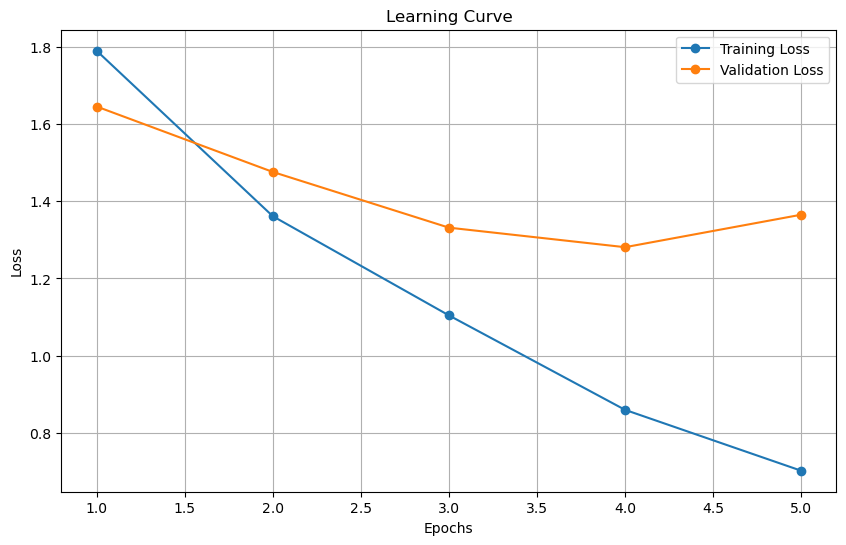

In [53]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS + 1), train_losses, label="Training Loss", marker="o")
plt.plot(range(1, EPOCHS + 1), val_losses, label="Validation Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend()
plt.grid(True)
plt.show()

Now let's plot the loss by epoch and batch. The x-axis here is a tuple of `(epoch, batch)`.

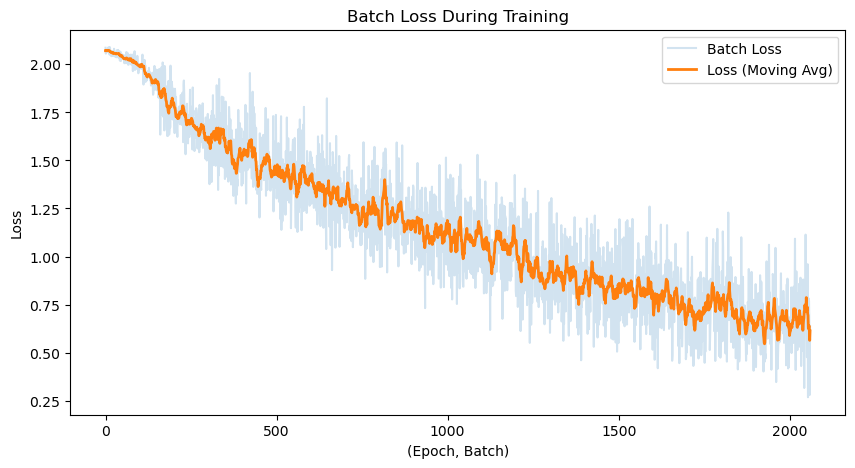

In [54]:
# Convert tracking_loss to a pandas Series for convenient rolling average
tracking_loss_series = pd.Series(tracking_loss_all)

# Plot
plt.figure(figsize=(10, 5))
tracking_loss_series.plot(alpha=0.2, label="Batch Loss")
tracking_loss_series.rolling(center=True, min_periods=1, window=10).mean().plot(
    label="Loss (Moving Avg)", linewidth=2
)
plt.xlabel("(Epoch, Batch)")
plt.ylabel("Loss")
plt.title("Batch Loss During Training")
plt.legend(loc="upper right")
plt.show()

Good news, the loss is going down! This is an encouraging start, especially since we haven't done anything fancy yet.

Note: In this version of the benchmark, the loss reaches 1.85 with the different randomness and params warning. The benchmark from the competition reaches 1.3. That is surprising.

In [ ]:
# torch.save(model, "model.pth")

### Predicted labels distribution
First let's review the species distribution we saw in the training set.

In [55]:
print("True labels (training):")
y_train.idxmax(axis=1).value_counts()

True labels (training):


civet_genet         2055
monkey_prosimian    1959
antelope_duiker     1867
leopard             1859
blank               1800
rodent              1535
bird                1324
hog                  772
Name: count, dtype: int64

In [56]:
# Extract predictions and true labels from eval_metrics
all_preds = eval_metrics["all_preds"]
all_labels = eval_metrics["all_labels"]

# Convert all_preds to DataFrame and map to class names
preds_df = pd.DataFrame(all_preds, columns=["predicted_class"])
preds_df["predicted_label"] = preds_df["predicted_class"].map(
    lambda idx: species_labels[idx]
)

# Convert all_labels to DataFrame and map to class names
labels_df = pd.DataFrame(all_labels, columns=["true_class"])
labels_df["true_label"] = labels_df["true_class"].map(
    lambda idx: species_labels[idx]
)

# Combine predictions and true labels for analysis
results_df = pd.concat([preds_df, labels_df], axis=1)

# Display value counts for predicted and true labels
print("Predicted labels (eval):")
print(results_df["predicted_label"].value_counts())

print("\nTrue labels (eval):")
print(results_df["true_label"].value_counts())

Predicted labels (eval):
predicted_label
monkey_prosimian    903
blank               548
civet_genet         484
antelope_duiker     412
leopard             362
rodent              297
bird                168
hog                 143
Name: count, dtype: int64

True labels (eval):
true_label
antelope_duiker     607
monkey_prosimian    533
rodent              478
blank               413
leopard             395
civet_genet         368
bird                317
hog                 206
Name: count, dtype: int64


### Accuracy
Now let's compute how accurate our model is and compare that against some trivial baseline models. First let's get the labels with the highest score for each image.

Random guessing across 8 classes would yield an accuracy of 12.5% (1/8). But we could construct a slightly better trivial model by always guessing the most common class ("monkey_prosimian" images in this case).

If we were to always guess that an image is `monkey_prosimian`, we could achieve accuracy of 15.8%.

In [58]:
# Convert all_labels (true labels) to their class names
eval_true = pd.Series(all_labels).apply(lambda x: species_labels[x])

# Simulate always guessing "monkey_prosimian"
monkey_predictions = pd.Series("monkey_prosimian", index=eval_true.index)

# Compute the accuracy of always predicting "monkey_prosimian"
benchmark_accuracy = (eval_true == monkey_predictions).sum() / len(monkey_predictions)

print(f"Benchmark Accuracy (always guessing 'monkey_prosimian'): {benchmark_accuracy:.4f}")


Benchmark Accuracy (always guessing 'monkey_prosimian'): 0.1607


In [59]:

eval_predictions = pd.Series(all_preds).apply(lambda x: species_labels[x])

# Calculate model accuracy
model_accuracy = (eval_predictions == eval_true).sum() / len(eval_true)

# Print results
print(f"Model Accuracy: {model_accuracy:.4f}")


Model Accuracy: 0.5237


In [60]:
# accuracy per class
per_class_accuracy = results_df.groupby("true_label").apply(
    lambda x: (x["true_label"] == x["predicted_label"]).mean()
)
print("Per-Class Accuracy:")
print(per_class_accuracy)


Per-Class Accuracy:
true_label
antelope_duiker     0.423394
bird                0.268139
blank               0.476998
civet_genet         0.676630
hog                 0.475728
leopard             0.668354
monkey_prosimian    0.793621
rodent              0.343096
dtype: float64


/var/folders/f9/_qvc3zsj1sg4_558kbgxv0d00000gn/T/ipykernel_14036/3003157961.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  per_class_accuracy = results_df.groupby("true_label").apply(


Let's look at the predictions from another angle.

We can see from the confusion matrix below that our model does reasonably well on some species, but we have plenty of room for improvement on antelopes, birds, hogs and blanks.

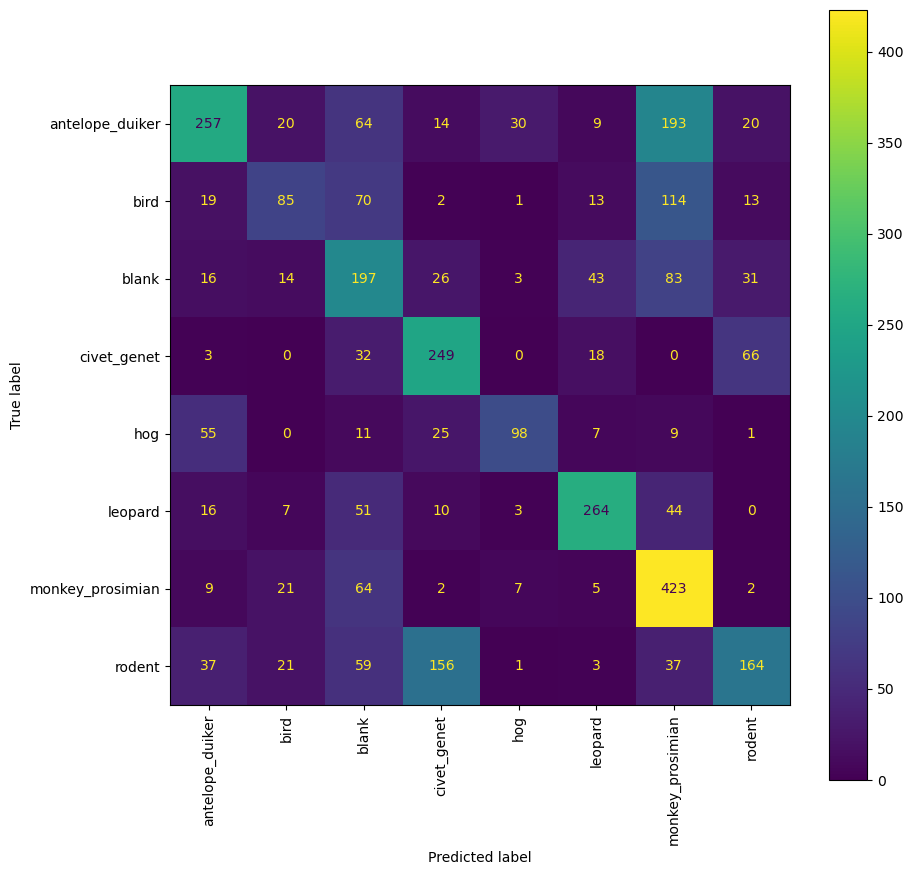

In [61]:
from sklearn.metrics import ConfusionMatrixDisplay

# Convert predictions to species names


# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
cm = ConfusionMatrixDisplay.from_predictions(
    eval_true,
    eval_predictions,
    ax=ax,
    xticks_rotation=90,
    colorbar=True,
)
plt.show()


That's where you come in! What can you do to improve on this benchmark?

Here are some ideas you might want to try:
* Train for more epochs. We've only done 1 so far.
* Try another pretrained model. For example, you may have more success with EfficientNet, or another ResNet model with more layers like ResNet152. See what's available from pytorch [here](https://pytorch.org/vision/stable/models.html). You may also want to review which models are or have been state of the art for image classification tasks, for example on [paperswithcode.com](https://paperswithcode.com/task/image-classification). Keep in mind that different models will require different input and output dimensions, so you'll need to update how you construct `model` above.
* Experiment with different loss functions.
* Experiment with different learning rates or learning rate schedulers.
* Add more layers to the model head (`model.fc`).
* You also may want to consider freezing the weights in the backbone model and only training the head (`model.fc`). If this results in higher accuracy, that suggests the current approach may be overwriting the backbone weights in a problematic way. One approach here would be to train just the model head, and then unfreeze the backbone but train at a lower learning rate.
* As you become more comfortable iterating through different versions of the model, you may want to try out [PyTorch Lightning](https://www.pytorchlightning.ai/) or [Lightning Flash](https://lightning-flash.readthedocs.io/en/latest/quickstart.html), which build upon PyTorch and eliminate a lot of boilerplate code, in addition to providing a more complete research framework for deep learning problems.

## 8. Create submission

Last but not least, we'll want to participate in the competition and see where we stand on the leaderboard.

To do this we need to create predictions for the **competition test set** (not the eval set we used above). You don't have labels for these.

We'll create predictions in the same way we did for the `eval` set, but this time using the `test_features` we downloaded from the [competition website](https://www.drivendata.org/competitions/87/competition-image-classification-wildlife-conservation/data/).

In [ ]:
# test_dataset = ImagesDataset(test_features.filepath.to_frame())
# test_dataloader = DataLoader(test_dataset, batch_size=32)

In [62]:
test_dataset = ImagesDataset(
    test_features, 
    transform=val_transform, 
    device=device)

# Create DataLoaders

test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, pin_memory=True)

In [63]:
print(f"Test set: {len(test_dataset)} samples")

Test set: 4464 samples


In [64]:
test_preds_collector = []

# put the model in eval mode so we don't update any parameters
model.eval()

# we aren't updating our weights so no need to calculate gradients
with torch.no_grad():
    for batch_n, batch in enumerate(test_loader):
        # run the forward step
        images = batch["image"].to(device)
        logits = model(images)

        # apply softmax so that model outputs are in range [0,1]
        preds = F.softmax(logits, dim=1)

        # store this batch's predictions in df
        # note that PyTorch Tensors need to first be detached from their computational graph before converting to numpy arrays
        preds_df = pd.DataFrame(
            preds.cpu().numpy(),
            index=batch["image_id"],
            columns=species_labels,
        )
        test_preds_collector.append(preds_df)

submission_df = pd.concat(test_preds_collector)


In [65]:
# Add 'id' as the index name
submission_df.index.name = 'id'
submission_df = submission_df.round(6)
submission_df

,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
id,,,,,,,,
ZJ016488,0.048686,0.001447,0.230780,0.095001,0.014133,0.595671,0.002747,0.011536
ZJ016489,0.616508,0.044786,0.030354,0.023032,0.149089,0.011544,0.099801,0.024886
ZJ016490,0.432758,0.014618,0.099790,0.304343,0.056257,0.019484,0.023995,0.048755
ZJ016491,0.000000,0.000000,0.000010,0.000000,0.000000,0.999990,0.000000,0.000000
ZJ016492,0.292243,0.118125,0.230700,0.004349,0.025938,0.002462,0.230531,0.095651
...,...,...,...,...,...,...,...,...
ZJ020947,0.144733,0.013775,0.722622,0.001375,0.019008,0.015853,0.071588,0.011045
ZJ020948,0.287168,0.041882,0.426830,0.003143,0.007469,0.030302,0.173164,0.030043
ZJ020949,0.088131,0.000302,0.251507,0.489464,0.047111,0.031740,0.001067,0.090678


Let's check a couple things on `submission_df` before submitting to the platform. We'll want to make sure our submission's index and column labels match the submission format. (The DrivenData platform will do these data integrity checks as well, but it will be quicker to detect problems this way.)

In [66]:
submission_format_path = "./data/givens/submission_format.csv"
submission_format = pd.read_csv(submission_format_path, index_col="id")


assert all(submission_df.index == submission_format.index)
assert all(submission_df.columns == submission_format.columns)

# Save submission_df for further use
submission_df_path = "./data/submissions/submission9.csv"
submission_df.to_csv(submission_df_path)

Looks like we're ready to submit! Save the dataframe out to a CSV file and then upload it via the [Submissions page](https://www.drivendata.org/competitions/87/competition-image-classification-wildlife-conservation/submissions/) on the competition website.

In [67]:
# ✨ W&B: Mark the run as complete (Or wait until the end of notebook)
wandb.finish()

epoch,▁▁▁▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆██████
eval_accuracy,▁▃▆██
eval_f1,▁▄▆██
eval_loss,█▅▂▁▃
eval_macro_f1,▁▅▆██
eval_precision,▁▄▇██
eval_recall,▁▃▆██
loss,███▇▇▅▅▄▆▅▅▆▄▄▃▃▃▄▅▂▃▃▂▂▃▂▃▂▃▃▁▂▃▂▁▂▁▁▂▂
epoch,4
eval_accuracy,52.3666
eval_f1,0.51529
